# Personalised Mecidine - Exploratory Data Analysis

## Goal of project
Automatically classify genetic mutations that contribute to cancer tumor growth drivers) vs. presence of mutations that don’t affect the tumors (passengers)

## Importing data

In [90]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
import re
%matplotlib inline

In [91]:
var_path = "Data/training_variants"
text_path = "Data/training_text"

d_train = pd.read_csv(var_path)
d_text = pd.read_csv(text_path, sep = "\|\|", skiprows=1, names = ['ID','Text'], engine="python")

## Variants file

### Variable Understanding

In [92]:
d_train.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
dtype: object

- ID - A specific gene of the specimen
- Gene - The specific gene where the mutation took place
- Variation - the nature of the mutation
- Class - Class which we must predict
    - between 1 and 9

In [93]:
d_train.apply(pd.Series.nunique)

ID           3321
Gene          264
Variation    2996
Class           9
dtype: int64

We now know that there are 3321 records in our training set - all of which are unique.
Although we have 264 unique genes and 2996 unique variations.
Lastly there are 9 classes.

In [94]:
d_train.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

We know that there are no null values in the dataset.

### Univariant Analysis

### Class

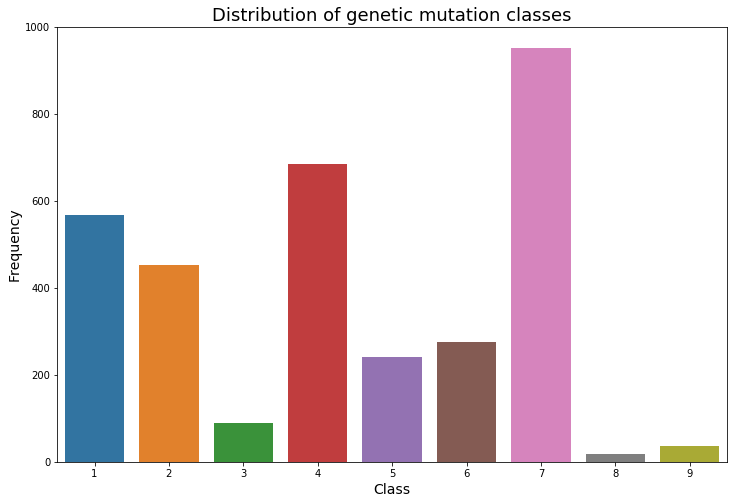

In [95]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=d_train)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

- Class 7 is very common, followed by 1, 2, and 4
- Class 3, 8, 9 are not very common

### Gene

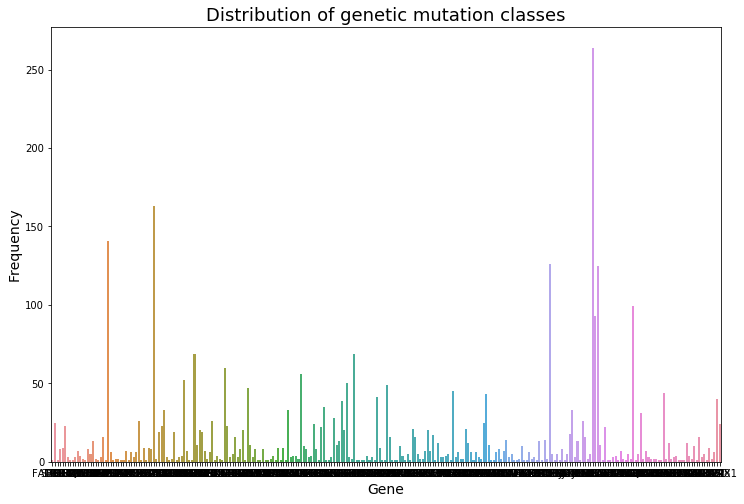

In [96]:
plt.figure(figsize=(12,8))
sns.countplot(x="Gene", data=d_train)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Gene', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

In [97]:
# Find top 10 genes
gene_freq = d_train['Gene'].value_counts()
print("Top-10 Gene Occurances\n")
print(gene_freq.head(10))

Top-10 Gene Occurances

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64


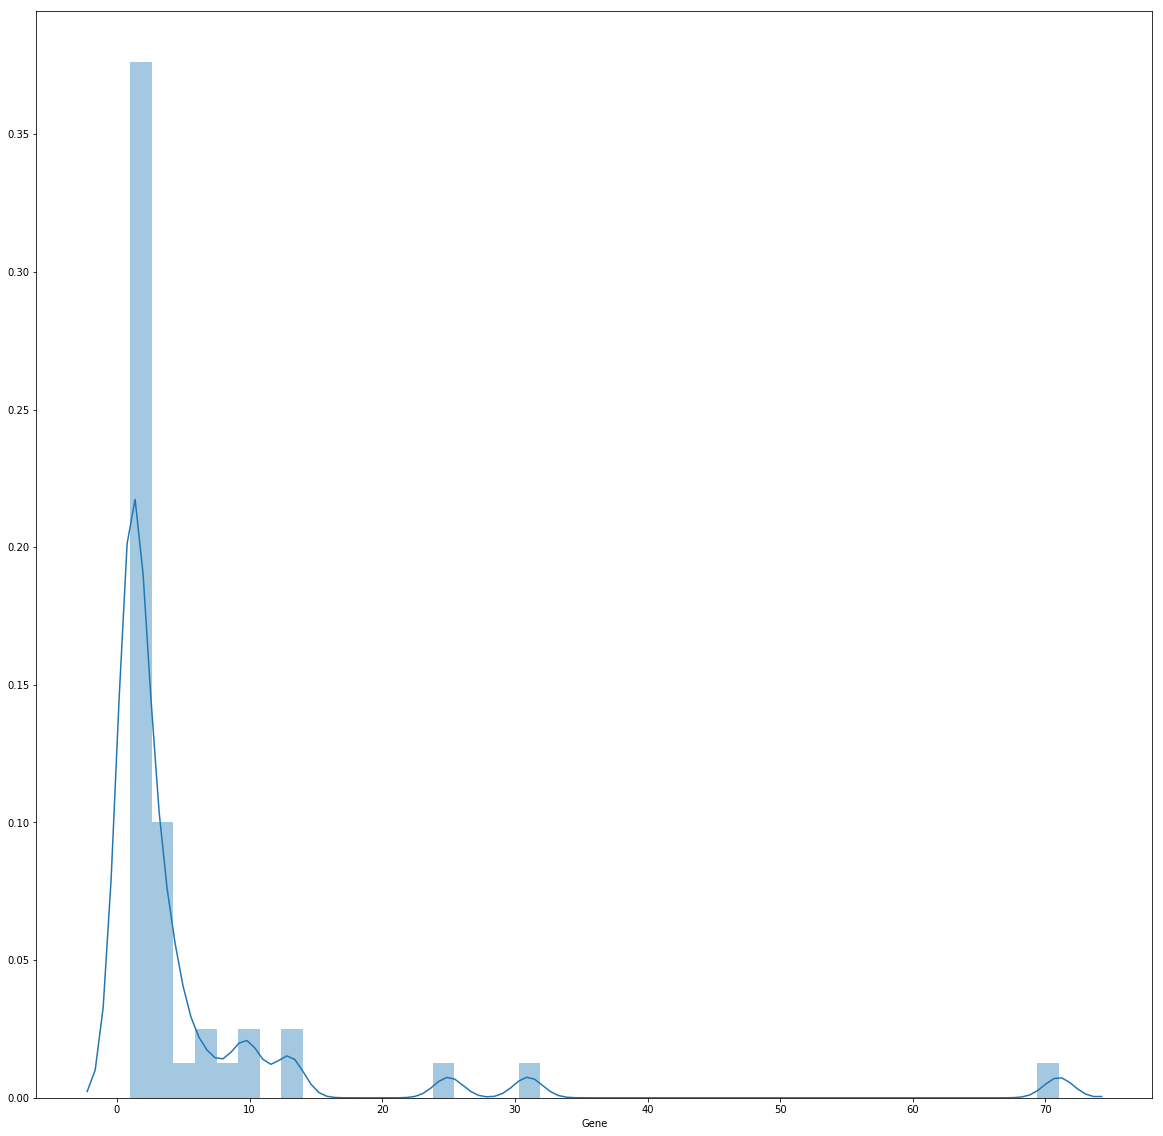

In [98]:
#Look at distribution of frequency of genes
plt.figure(figsize=(20,20))
sns.distplot(gene_freq.value_counts())

- There are a lot of genes that appear only once, and quite a few appear twice

In [99]:
#Get frequency and standard deviation for genes occuring more than once
filter_genes = gene_freq[gene_freq > 2]
print(stats.kurtosis(filter_genes),stats.skew(filter_genes))

24.253454297558463 4.360256036389982


### Variation

In [100]:
print("Description of Variation")
print(d_train['Variation'].describe())
print("\nTop Five Variations")
print(d_train['Variation'].value_counts().head(5))

Description of Variation
count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

Top Five Variations
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
Name: Variation, dtype: int64


- There are a lot of unique variation
- Only the top foud variations appear somewhat often
- Variation may not provide much information

## Bivariant Analysis

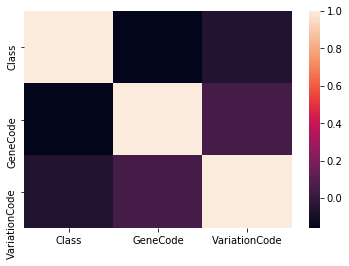

In [101]:
# Converting Gene and Variation to categories
d_train['Gene'] = d_train['Gene'].astype('category')
d_train['Variation'] = d_train['Variation'].astype('category')
d_train['Gene'].head().cat.codes
d_train['GeneCode'] = d_train['Gene'].cat.codes
d_train['VariationCode'] = d_train['Variation'].cat.codes
d_train.head()

# Calculate correlations
corr = d_train[['Class', 'GeneCode', 'VariationCode']].corr()

# Heatmap
sns.heatmap(corr)
plt.figure(figsize=(10,10))
plt.show()

- There does not appear to be much correlation anywhere

### Gene and Variation

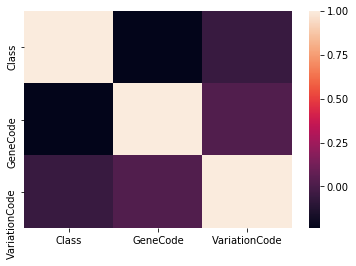

In [102]:
#Correlation using top 20 genes
top_20_genes = d_train[(d_train['Gene'].isin(gene_freq.head(20).index))]

# Calculate correlations
corr = top_20_genes[['Class', 'GeneCode', 'VariationCode']].corr()

# Heatmap
sns.heatmap(corr)
plt.show()

- Slightly better, but still does not appear to have much correlation

### Top 20 Gene Distribution by Class

In [103]:
#top_20_genes.head()
#g = sns.factorplot("Gene", hue="Gene", col="Class", data=top_20_genes, kind="count")

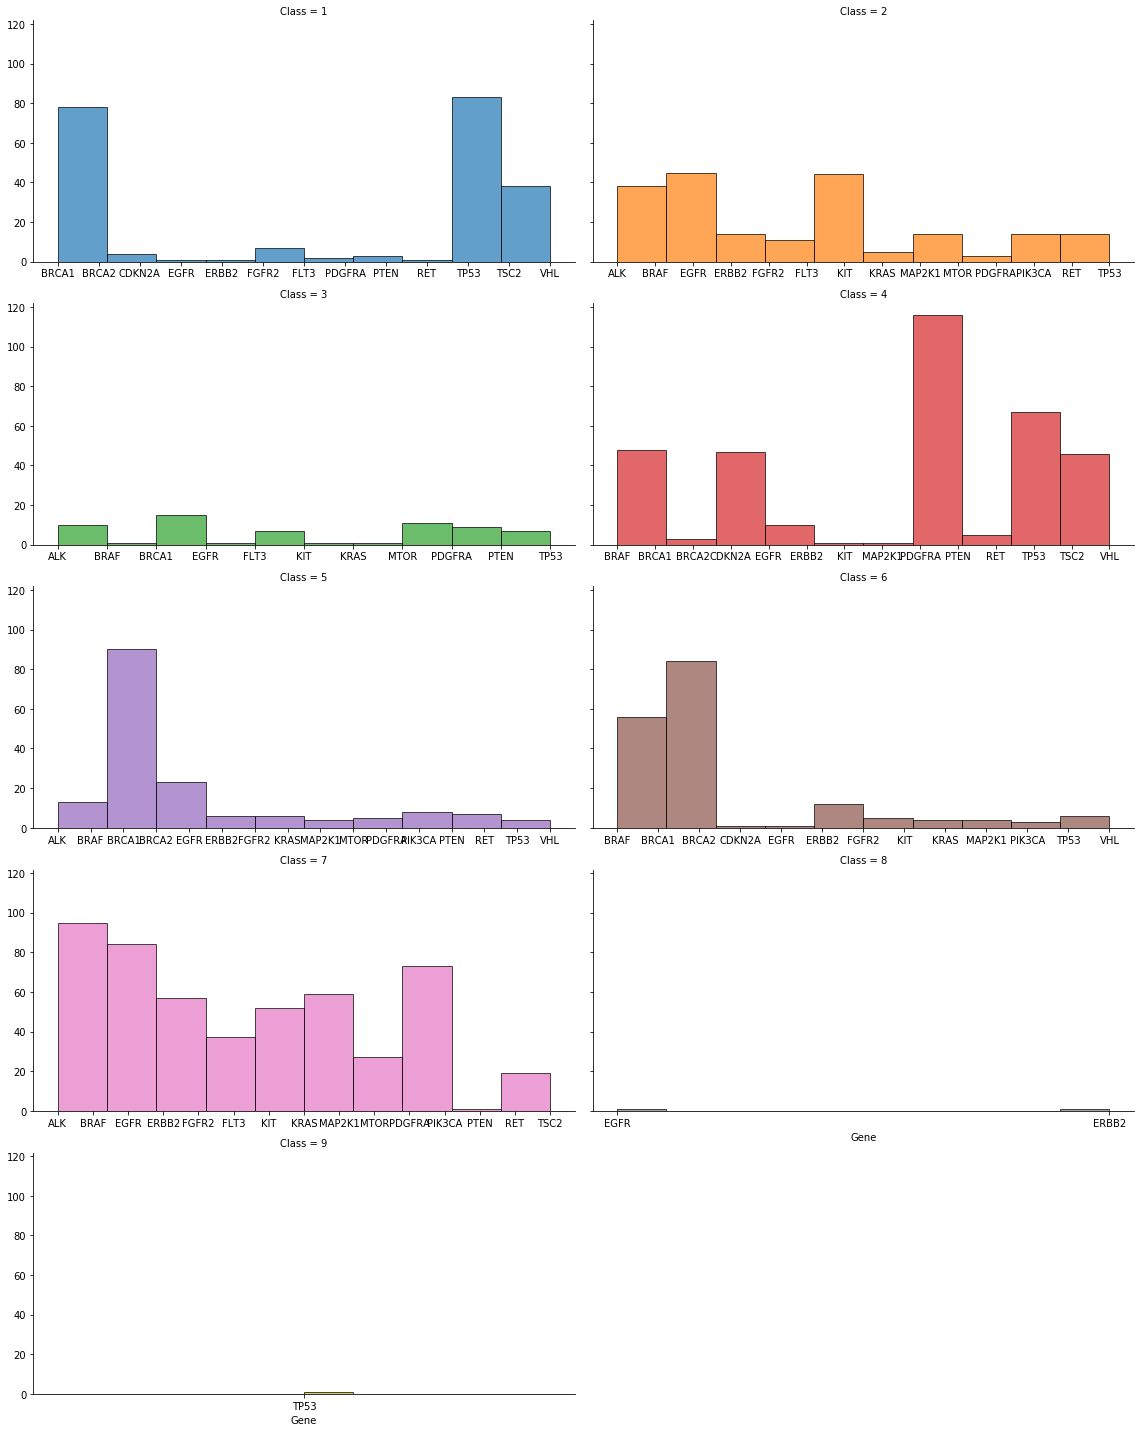

In [104]:
g = sns.FacetGrid(top_20_genes, col="Class", col_wrap=2, size=4, aspect=2, hue="Class", margin_titles=True, sharex=False)
g.map(plt.hist, "Gene", alpha=0.7, edgecolor='#000000');
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
plt.tight_layout()

## Text File (Natural Language Processing)

### Categorize by Class

In [105]:
merged_data = pd.merge(d_train,d_text,on='ID')
merged_data['Class'].value_counts()


7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [106]:
#Get class1 text
class1_text = merged_data[merged_data['Class'] == 1]['Text']
class1_text = pd.DataFrame(class1_text)
class1_text = class1_text.reset_index(drop=True)
class1_text

,Text
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL is a negative regulator of activated recep...
2,To determine if residual cylindrical refractiv...
3,Sex cord–stromal tumors and germ-cell tumors a...
4,Sex cord–stromal tumors and germ-cell tumors a...
5,Mesenchymal cell populations contribute to mic...
6,Mesenchymal cell populations contribute to mic...
7,The receptor protein tyrosine phosphatase T (P...
8,The receptor protein tyrosine phosphatase T (P...
9,Receptor protein tyrosine phosphatase T (PTPRT...


In [107]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  
clean_review = review_to_words( class1_text["Text"][0] )
print(clean_review)

cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk silencing increases ets v ets erythroblastosis virus e oncogene homolog driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk modulates ets activity generally functions cdk remain elusive demonstrate cdk cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk cyclin silencing phenocopies cdk silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk cyclin phosphorylates ets vitro cells positively controls ets degradation proteasome ets protein levels increased cells derived star patien

In [108]:
# Get the number of reviews based on the dataframe column size
num_reviews = class1_text["Text"].size

print("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print("Review %d of %d\n" % ( i+1, num_reviews ))                                                               
    clean_train_reviews.append( review_to_words( class1_text["Text"][i] ))

Cleaning and parsing the training set movie reviews...



In [109]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [110]:
print(train_data_features.shape)

(568, 5000)


In [111]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab)

['aa', 'aacr', 'aacrjournals', 'ab', 'abbreviations', 'abc', 'abcam', 'aberrant', 'aberrations', 'abh', 'abi', 'ability', 'abl', 'able', 'abnormal', 'abnormalities', 'abnormality', 'abolish', 'abolished', 'abolishes', 'abrogate', 'abrogated', 'abrogation', 'absence', 'absent', 'absolute', 'absolutely', 'abstract', 'abt', 'abundance', 'abundant', 'ac', 'aca', 'acc', 'accelerated', 'accepted', 'acceptor', 'access', 'accessible', 'accession', 'accommodate', 'accompanied', 'accompanying', 'accordance', 'according', 'accordingly', 'account', 'accounted', 'accounting', 'accounts', 'accumulate', 'accumulated', 'accumulates', 'accumulation', 'accuracy', 'accurate', 'acetate', 'acetyl', 'acetylated', 'acetylation', 'achieve', 'achieved', 'acid', 'acidic', 'acids', 'acinar', 'acknowledgments', 'acquire', 'acquired', 'acquisition', 'across', 'act', 'actin', 'acting', 'action', 'activate', 'activated', 'activates', 'activating', 'activation', 'activator', 'activators', 'active', 'actively', 'activ

In [112]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)
print(train_data_features)
print(type(vocab))
# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

[[ 0  0  0 ...,  0  0  0]
 [ 0  0 17 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 ..., 
 [ 6  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0 10  0]]
<class 'list'>
950 aa
92 aacr
218 aacrjournals
215 ab
73 abbreviations
250 abc
132 abcam
689 aberrant
519 aberrations
100 abh
276 abi
3341 ability
249 abl
870 able
415 abnormal
598 abnormalities
174 abnormality
324 abolish
310 abolished
93 abolishes
210 abrogate
240 abrogated
122 abrogation
1834 absence
405 absent
120 absolute
94 absolutely
228 abstract
118 abt
197 abundance
142 abundant
337 ac
180 aca
561 acc
121 accelerated
179 accepted
234 acceptor
530 access
564 accessible
288 accession
109 accommodate
174 accompanied
69 accompanying
218 accordance
1911 according
195 accordingly
439 account
103 accounted
74 accounting
125 accounts
151 accumulate
129 accumulated
80 accumulates
642 accumulation
156 accuracy
112 accurate
97 acetate
69 acetyl
78 acetylated
303 acetylation
140 achieve
262 achieved
3521 acid
293 acidic
2565 ac

2058 classification
228 classifications
1458 classified
202 classify
94 classifying
967 clear
602 clearly
252 cleavage
113 cleaved
101 cleft
156 clinic
3773 clinical
331 clinically
96 clinicians
97 clinicopathologic
205 cll
398 clonal
507 clone
457 cloned
977 clones
296 cloning
79 clonogenic
194 clontech
731 close
172 closed
285 closely
621 cluster
231 clustered
315 clustering
200 clusters
430 cm
227 cml
88 cmml
76 cmr
126 cmv
164 cns
2802 co
233 coactivator
95 coactivators
154 coaggregation
127 coated
94 cocktail
239 code
81 coded
129 codes
1330 coding
1971 codon
646 codons
146 coefficient
114 coexpressed
149 coexpression
438 cohesin
105 cohesion
1143 cohort
327 cohorts
149 coil
135 coiled
189 coimmunoprecipitation
165 cold
546 coli
141 collagenase
209 colleagues
522 collected
291 collection
195 collectively
140 colocalization
1094 colon
132 colonic
589 colonies
639 colony
224 color
1752 colorectal
201 colored
144 coloured
288 column
115 columns
529 com
687 combination
206 combination

194 flexible
568 flow
117 flox
709 flt
640 fluorescence
369 fluorescent
100 fluoride
187 fm
372 fniii
238 fo
280 focal
439 foci
366 focus
265 focused
2177 fold
472 folded
916 folding
152 follicular
294 follow
1029 followed
2219 following
305 follows
2473 form
97 formaldehyde
160 formalin
90 formally
75 format
2734 formation
709 formed
178 former
261 forming
1162 forms
149 forty
501 forward
102 foster
5930 found
112 foundation
401 founder
3040 four
144 fourth
733 foxa
577 foxo
242 foxp
124 fr
1290 fraction
119 fractionation
364 fractions
969 fragment
716 fragments
1097 frame
1106 frameshift
88 frameshifts
141 framework
97 france
191 fraumeni
865 free
164 french
592 frequencies
2434 frequency
699 frequent
1125 frequently
154 fresh
242 frozen
797 fs
80 fsrc
227 fubp
123 fugene
70 fulfill
104 fulfilled
112 fulgidus
2579 full
461 fully
8475 function
6441 functional
101 functionality
724 functionally
79 functioning
1909 functions
146 fundamental
1485 furthermore
323 fused
1412 fusion
244 fus

314 methylated
1267 methylation
255 methyltransferase
912 mg
183 mga
176 mgcl
1197 mh
151 mhc
4135 mice
326 microarray
209 microattribution
86 microenvironment
694 microsatellite
263 microscope
253 microscopy
100 microtubule
359 middle
2126 might
70 migrated
131 migrating
498 migration
358 mild
103 milder
115 milk
160 million
100 millipore
285 mim
112 mimic
1613 min
121 mini
263 minigene
364 minimal
244 minimum
313 minor
121 minority
423 minutes
115 mip
131 mir
371 mirna
160 mirnas
141 misfolded
80 misfolding
887 mismatch
87 mismatches
69 missed
5292 missense
135 missing
70 mitochondria
96 mitochondrial
71 mitogen
69 mitomycin
201 mitosis
231 mitotic
183 mix
430 mixed
289 mixture
330 mkk
2242 ml
2155 mlh
106 mlk
1159 mll
318 mlpa
2948 mm
289 mmc
259 mmol
209 mmp
1606 mmr
76 mms
75 mmtv
91 mn
312 mo
296 mobility
180 mock
176 mode
2610 model
93 modeled
319 modeling
106 modeller
1146 models
386 moderate
198 moderately
252 modest
331 modification
426 modifications
477 modified
115 modify
9

271 reveals
986 reverse
106 reversed
76 reversible
609 review
553 reviewed
166 rhabdoid
75 rhd
454 rheb
130 rho
506 rhoa
139 ri
83 ribbon
86 ribosomal
529 rich
239 ridge
782 right
237 rigid
71 rigidity
260 rii
549 ring
69 rinsed
78 ripa
251 rise
2880 risk
310 risks
83 rita
134 rmce
154 rmsd
2476 rna
232 rnai
72 rnapii
122 rnas
143 rnase
84 rneasy
307 rnf
224 robust
86 roc
409 roche
137 rock
4052 role
746 roles
346 room
87 root
84 rosa
137 round
126 routine
79 routinely
313 row
159 rp
79 rpm
207 rpmi
100 rr
255 rras
395 rs
72 rsk
1377 rt
82 rtk
108 ruediger
182 rule
309 rules
201 run
71 runs
1343 runx
108 rybp
81 sa
95 saccharomyces
156 saline
243 salt
1431 sample
4356 samples
179 san
290 sandwich
402 sanger
498 santa
533 saos
90 sapiens
625 sara
244 sarcoma
100 sarcomas
120 sb
118 sbc
200 sc
293 scaffold
379 scaffolding
618 scale
81 scanned
196 scanning
80 scattered
132 scc
81 scchn
127 sccoht
133 scd
118 scei
69 scenario
113 scf
375 schematic
177 scheme
72 school
74 schwannoma
74 schw

In [140]:
df1 = pd.DataFrame(vocab, columns=['word'])
df2 = pd.DataFrame(dist, columns=['count'])
df.head(10)
df2.head(10)
df3 = pd.concat([df1, df2], axis=1)
df3.head(10)
df3.set_index('word')
df3 = df3.sort_values('count', ascending=False)
df3.head()
df4 = df3.set_index('word')['count']
print(df4)
d = df4.to_dict()
print(d)

word
mutations          33881
cells              28555
cell               20386
al                 18995
et                 18975
protein            18167
fig                18159
cancer             18145
figure             17897
mutation           17316
dna                15484
binding            15465
type               15215
expression         14574
smad               14554
variants           13801
brca               13672
gene               12884
mutant             12731
wild               12036
tumor              11925
domain             11301
also               11170
using              10732
data               10588
analysis           10584
activity           10173
two                10027
table               9666
genes               9575
                   ...  
mitomycin             69
let                   69
african               69
accompanying          69
tq                    69
tetracycline          69
intellectual          69
tcr                   69
lymphomagenesis     

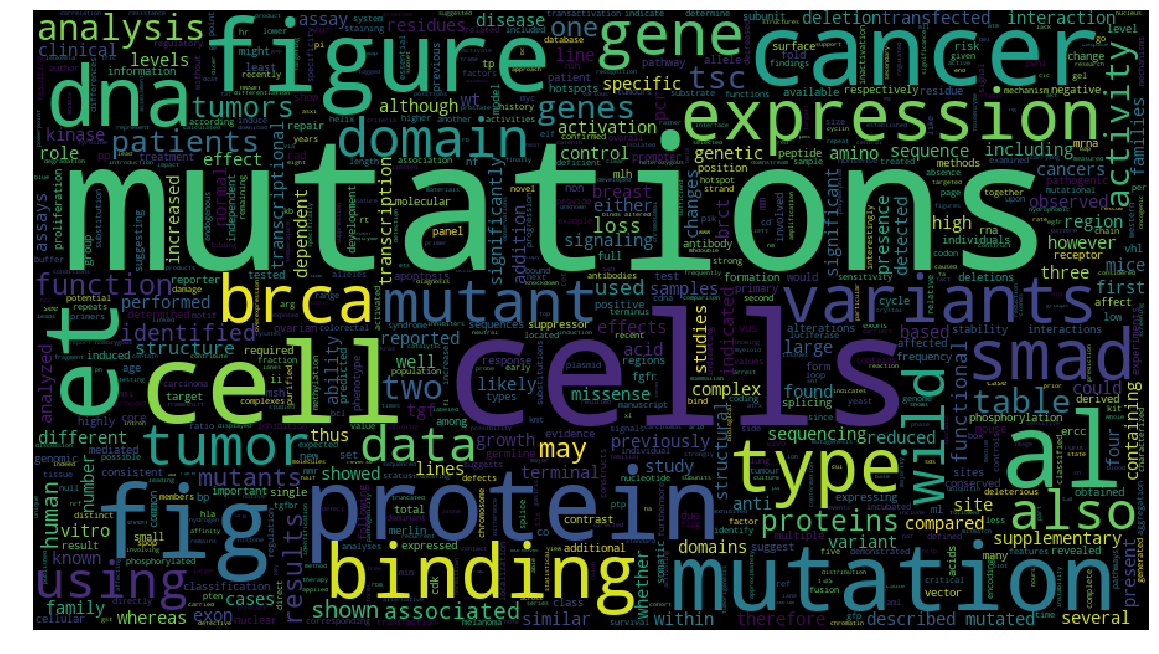

In [141]:
from wordcloud import WordCloud
cloud = WordCloud(background_color="white")

positive_cloud = WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)
plt.figure(figsize=(20,20))
plt.imshow(positive_cloud)
plt.axis("off")
plt.show()

## Challenges

- Learning to deal with common challenges of text mining
- Using Natural Language processing libraries/toolkits in a Biomedical environment
    - Proposed solution: Biomedical terminology banks are available for the purposes of text mining although operating system restrictions and pay walls must be overcome. 
- Some test data is machine generated therefore text analysis may give unusual results
    - Proposed solution: Parse through machine generated text and differentiate between noise and actual data.

## Timeline

- Data Exploration: January 22, 2018 - February 5, 2018 (Weeks 3-5)
- Data Preparation: February 5, 2018 - March 2, 2018 (Weeks 5-8)
- Modeling: March 2, 2018 - March 20, 2018 (Weeks 8-10)
- Documentation and Poster: March 20, 2018 - April 6, 2018 (Weeks 10-12)